<a href="https://colab.research.google.com/github/dsiervo/GNN_Martijn_Ampuero/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp "/content/drive/My Drive/GNN_Martijn_Ampuero/graph_model.py" .

In [3]:
!cat graph_model.py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Reshape, RepeatVector
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization, Lambda, Multiply, Permute
from tensorflow.keras.layers import Activation, SpatialDropout2D, UpSampling2D
from tensorflow.keras.layers import GaussianNoise, GaussianDropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd
import os
import pickle


class DataGenerator(keras.utils.Sequence):

    def __init__(self, data_dir, catalogue, stations, lookup, N_sub, N_t, batch_size):
        """
        stations: (N_stations x 2)
        catalogue: (N_events x 5) {ID, lat, lon, depth, mag}
        """
        
        self.data_dir = data_dir
        self.cat = catalogue
        self.stations = stations
        

In [4]:
# Import modules

%matplotlib inline

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from graph_model import CallBacks, DataGenerator, GraphNet

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import shutil

In [5]:
import tensorflow as tf

tf.__version__

'2.3.0'

In [6]:
# Define the data directories

model_name = "max-aggregate2_dropout=0.15+Gaussian"

cwd = "/content/drive/My Drive/GNN_Martijn_Ampuero"
data_dir = os.path.join(cwd, "data")
processed_waveform_dir = os.path.join(data_dir, "waveforms_proc_broadband")

# Data preparation

In [7]:
# Fix random seed for reproducibility
np.random.seed(0)

# Data ranges (min/max)
minlatitude = 32
maxlatitude = 36
minlongitude = -120
maxlongitude = -116
maxdepth = 30e3
minmag = 3
maxmag = 6

# Fraction of the data to be used in training
split = 0.8

As part of the data preparation process, we scale the data within the range of $\pm 1$, and split the data set into a training set and a validation set.

1377


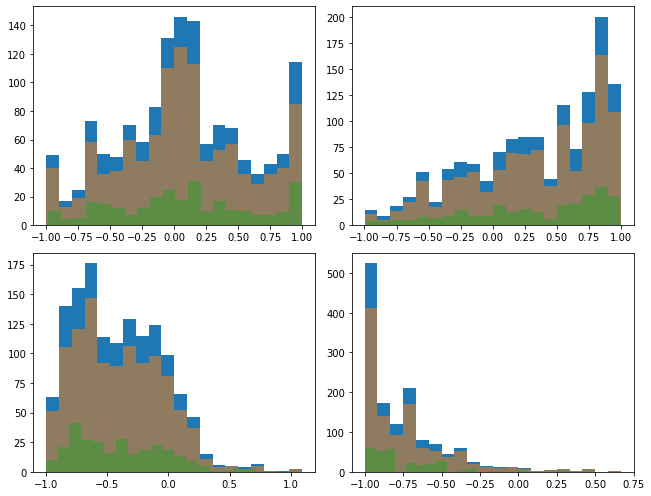

In [8]:
# Get the event catalogue
catalogue = pd.read_csv(os.path.join(data_dir, "catalogue.csv"))[["lat", "lon", "depth", "mag"]]

# Check which events have data
for i, event in catalogue.iterrows():
    # Event data file
    cat_file = os.path.join(processed_waveform_dir, "%d.npy" % i)
    # If file not exists: remove event from catalogue
    if not os.path.isfile(cat_file):
        catalogue.drop(index=i, inplace=True)

# Print number of events
print(len(catalogue))        

# Event identifiers
ids = catalogue.index.values
# Uniform weights
weights = np.ones((len(ids), 1))
# Event lat/lon/depth/magnitude
catalogue = catalogue.values

# Scale data
catalogue[:, 0] = (catalogue[:, 0] - minlatitude) / (maxlatitude - minlatitude)
catalogue[:, 1] = (catalogue[:, 1] - minlongitude) / (maxlongitude - minlongitude)
catalogue[:, 2] = catalogue[:, 2] / maxdepth
catalogue[:, 3] = (catalogue[:, 3] - minmag) / (maxmag - minmag)

catalogue = (catalogue - 0.5) * 2

# Concatenate identifiers and weights to event data
catalogue = np.concatenate([ids.reshape(-1, 1), weights.reshape(-1, 1), catalogue], axis=1)

# Randomly split events into train and validation sets
inds = np.arange(catalogue.shape[0])
np.random.shuffle(inds)
N_split = int(split * catalogue.shape[0])

train_inds = inds[:N_split]
test_inds = inds[N_split:]

# Split catalogue
train_catalogue = catalogue[train_inds]
test_catalogue = catalogue[test_inds]

# Check data distributions to ensure that train and validation sets are similar!
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
axes = axes.ravel()

for i in range(4):
    ax = axes[i]
    ax.hist(catalogue[:, i+2], bins=20, density=False)
    ax.hist(train_catalogue[:, i+2], bins=20, alpha=0.5, density=False)
    ax.hist(test_catalogue[:, i+2], bins=20, alpha=0.5, density=False)

plt.tight_layout()    
plt.show()

In [9]:
# Read seismic station information
stations = pd.read_csv(os.path.join(data_dir, "stations.csv"))[["code", "lat", "lon"]]
# Scale station geographic locations
stations["lat"] = ((stations["lat"] - minlatitude) / (maxlatitude - minlatitude) - 0.5) * 2
stations["lon"] = ((stations["lon"] - minlongitude) / (maxlongitude - minlongitude) - 0.5) * 2

In [10]:
# Open the event-station lookup file
lookup_file = os.path.join(data_dir, "catalogue_station_lookup_final.pickle")

with open(lookup_file, "rb") as f:
    lookup = pickle.load(f)

In [11]:
# Number of stations per sample
N_sub = 50
# Number of time sample points
N_t = 2048

# Instantiate train data generator
train_generator = DataGenerator(
    data_dir=processed_waveform_dir,
    catalogue=train_catalogue,
    stations=stations,
    lookup=lookup,
    N_sub=N_sub,
    N_t=N_t,
    batch_size=32,
)

# Instantiate validation data generator
test_generator = DataGenerator(
    data_dir=processed_waveform_dir,
    catalogue=test_catalogue,
    stations=stations,
    lookup=lookup,
    N_sub=N_sub,
    N_t=N_t,
    batch_size=32,
)

# Model construction

In [12]:
""" Define Tensorflow/Keras callbacks """

# Tensorboard log directory
logdir = os.path.join("logs", model_name)
if os.path.isdir(logdir):
    shutil.rmtree(logdir)

# Save model directory
savedir = os.path.join("save", model_name)
if not os.path.isdir(savedir):
    os.makedirs(savedir)

# Best and last model save files
savefile_best = "best-model.h5"
savefile_last = "last-model.h5"

# Instantiate callbacks
tensorboard_callback = CallBacks.tensorboard(logdir)
checkpoint_callback_best = CallBacks.checkpoint(os.path.join(savedir, savefile_best), best=True)
checkpoint_callback_last = CallBacks.checkpoint(os.path.join(savedir, savefile_last), best=False)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 2048, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 2048, 4)  64          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 2048, 4)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 50, 2048, 4)  0           activation[0][0]                 
_______________________________________________________________________________________

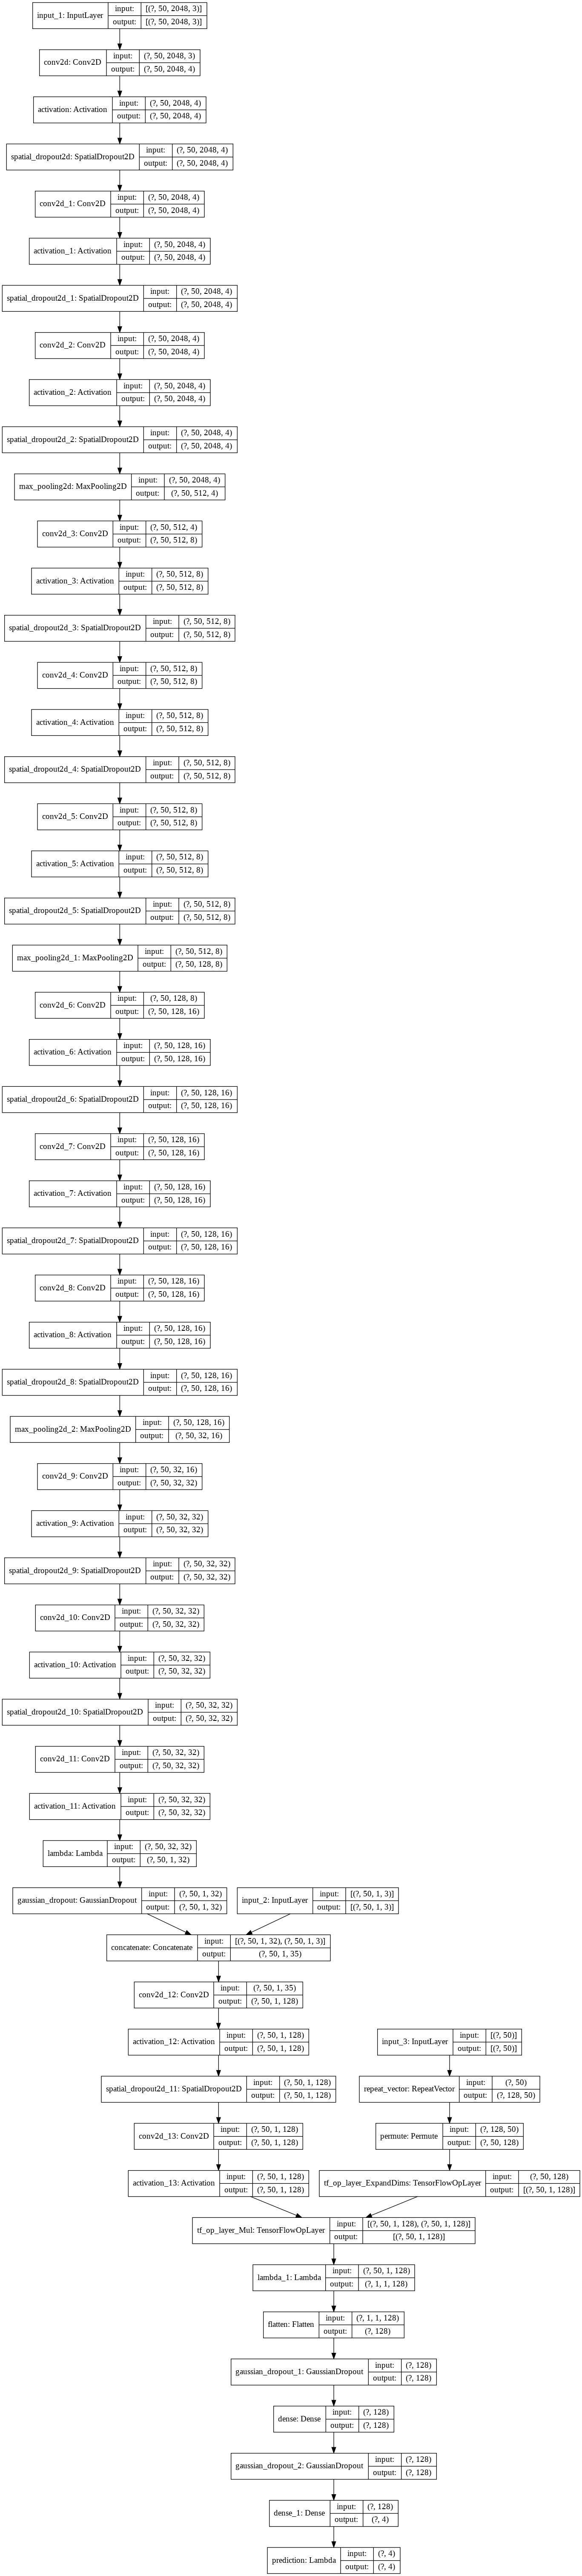

In [13]:
# Instantiate Graph Neural Network
graph = GraphNet()
# Overwrite default model parameters
params = {
    "N_t": N_t,
    "dropout_rate": 0.15,
    "activation": "relu",
}
# Set parameters
graph.set_params(params)
# Construct a graph model
model = graph.construct()
# Print out a summary
model.summary()
# Output model summary to a PNG image (if possible)
plot_model(model, show_shapes=True)

In [14]:
graph.LR

0.0002

In [15]:
# Compile the model with an ADAM optimiser and mean absolute error loss function
model.compile(
    optimizer=Adam(learning_rate=graph.LR),
    loss="mean_absolute_error",
)

# Train the model for 500 epochs
model.fit(
    train_generator,
    validation_data=test_generator
)

AttributeError: ignored